**PROBLEM DEFINITION**

The overall goal of this project is to analyze a dataset of Wine Reviews and build a proof of concept machine learning model to predict wine ratings. This model will then be evaluated on a test dataset and the results of this assessment will serve as a basis of decision to implement a full production solution.

In our Wine Review dataset, experts rate different wines through the 100-point wine-scoring scale:

- 95-100 Classic: a great wine
- 90-94 Outstanding: a wine of superior character and style
- 85-89 Very good: a wine with special qualities
- 80-84 Good: a solid, well-made wine
- 75-79 Mediocre: a drinkable wine that may have minor flaws
- 50-74 Not recommended

Source: Wine Spectator 

https://www.winespectator.com/articles/scoring-scale


In addition to the score given to a specific wine, each column of the dataset provides a pieces of information that can be relevant to our predictor. The columns of the dataset are as follows: 

- Country: Country of origin
- Description: Description of the wine by the taster 
- Designation: The vineyard within the winery where the grapes are from
- Points: Points given by the taster
- Price: Price of a bottle
- Province: The province or state where the wine came from 
- Region_1: The area in the province where the grapes are grown 
- Region_2: Specific region within Region 1
- Taster name: Name of the expert that tasted the wine
- Taster twitter handle: Twitter handle of the taster
- Title: Title of the wine 
- Variety: Variety of the grape
- Winery: Winery where the wine was produced 

Following the convention on Machine Learning projects, the 'Points' column will be referred to as our target, since it is the information we want to predict, and the columns will be referred as the features, which will be used to train our model. 

Since the dataset provides labeled examples and the target is a number between 50 and 100, we will use the supervised learning technique *regression*.

Our project will go through the following steps: 
1. Clean and format dataset
2. Exploratory data analysis
3. Feature extraction
4. Feature selection - MUVR Algorithm
5. Model training
6. Evaluation 
7. Conclusion

***CLEAN AND FORMAT DATASET***

In this first step, we will take a closer look at our data, drop irrelevant features and treat null values.

IMPORTS - packages that will be used throughout this notebook

In [1]:
import re
import pandas as pd
import seaborn as sns
from datetime import date
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import qqplot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

The head() method shows the first five rows in our dataset, so we can see more concrete examples of our data. 

The first thing we notice is that we have numerical and categorical features. In due time, we will need to make adjustments so all our features are numerical, since machine learning models cannot work directly with categorical features. 

Also, we can see that some of the columns have NaN values, meaning that those values are missing and we must decide how to deal with that. 

In [2]:
# Read data to pandas dataframe
df = pd.read_csv('wine_dataset.csv')

# Display 5 first rows of dataframe
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


DROPPING IRRELEVANT FEATURES

Using some intuition, we can already drop some features that are very likely to not generate relevant information to our analysis.

- Calling info() method gives us a little more information about the columns in our dataset. Looking to the non-null count we notice that the **region_2** value is missing in 61.47% of the rows. We will assume that the feature is not relevant and can be dropped from our analysis. 

- Printing the number of unique values, we can see that **designation** and **winery** are very high cardinality features (over 5000 unique values in a 10000 row dataset). These features talk about the location where the wine came from, but we already have three other features that have information about location (country, province and region_1). Therefore, we will assume that they can also be dropped from further analysis.

- **Description** and **title** are unique to every wine, but they bring relevant information and will be used in the next sections for feature extraction

- Both the **taster_name** and the **taster_twitter_handle** features point to the expert that is tasting the wine. They are redundant, so we will also drop the twitter handle column. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             10000 non-null  int64  
 1   country                9994 non-null   object 
 2   description            10000 non-null  object 
 3   designation            7171 non-null   object 
 4   points                 10000 non-null  int64  
 5   price                  9323 non-null   float64
 6   province               9994 non-null   object 
 7   region_1               8336 non-null   object 
 8   region_2               3853 non-null   object 
 9   taster_name            8015 non-null   object 
 10  taster_twitter_handle  7644 non-null   object 
 11  title                  10000 non-null  object 
 12  variety                10000 non-null  object 
 13  winery                 10000 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.1+ 

In [4]:
print("Number of unique values in each column:") 
for column in df.columns:
    print(column + " : " + str(df[column].nunique()))

Number of unique values in each column:
Unnamed: 0 : 10000
country : 37
description : 9942
designation : 5381
points : 21
price : 188
province : 248
region_1 : 724
region_2 : 17
taster_name : 18
taster_twitter_handle : 14
title : 9930
variety : 333
winery : 5460


In [5]:
df = df.drop(columns = ['Unnamed: 0', 'designation', 'region_2', 'taster_twitter_handle', 'winery'])
df.head()

,country,description,points,price,province,region_1,taster_name,title,variety
0,Italy,"Fragrances suggest hay, crushed tomato vine an...",90,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon
1,France,"Packed with fruit and crisp acidity, this is a...",87,22.0,Loire Valley,Sancerre,Roger Voss,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé
2,Italy,"This easy, ruby-red wine displays fresh berry ...",86,NaN,Tuscany,Chianti Classico,NaN,Dievole 2009 Chianti Classico,Sangiovese
3,US,Pretty in violet and rose petals this is a low...,92,50.0,California,Russian River Valley,Virginie Boone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir
4,US,This golden wine confounds in a mix of wet sto...,93,38.0,California,Russian River Valley,Virginie Boone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay


DROPPING DUPLICATES

Dropping duplicate rows leaves us with 9942 examples in the dataset.

In [6]:
df = df.drop_duplicates(ignore_index=True)
print(len(df))

9942


DEALING WITH NULL VALUES

Now is time to decide what to do about the null values in our dataset. 
Summing the null values per row shows us that 4008 rows have at least 1 null value. 
This means that dropping every row that has null values will get read of approximately 40% of our dataset, which is completely unacceptable.

In [7]:
nulls_per_row = df.isnull().sum(axis=1)
Counter(sorted(nulls_per_row))

Counter({0: 5934, 1: 3700, 2: 301, 3: 6, 4: 1})

Another way to deal with null values is to fill them with the median for that column. Or, in the case of categorical values, with the most common value. The median is chosen over the mean here because it less affected by outliers.

- Missing values in **Price** will be filled with the median.
- Missing values in **Country**, **Region_1** and **Province** will be filled with the most common value. 
- Missing values in **Taster Name** will be filled with 0. 

The reason that we chose to fill the nulls in taster name with 0 is because it is a low cardinality features, that is, there aren't that many different tasters in the dataset. The zero value will simply represent that the value is unknown.

After this, we run dataset info one more time to check that we have no null values. 

In [8]:
df['price'].fillna(df['price'].median(), inplace=True)
df['country'].fillna(str(df['country'].mode()), inplace=True)
df['province'].fillna(str(df['province'].mode()), inplace=True)
df['region_1'].fillna(str(df['region_1'].mode()), inplace=True)
df['taster_name'].fillna(0, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9942 entries, 0 to 9941
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      9942 non-null   object 
 1   description  9942 non-null   object 
 2   points       9942 non-null   int64  
 3   price        9942 non-null   float64
 4   province     9942 non-null   object 
 5   region_1     9942 non-null   object 
 6   taster_name  9942 non-null   object 
 7   title        9942 non-null   object 
 8   variety      9942 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 699.2+ KB


***EXPLORATORY DATA ANALYSIS***

Now that we have cleaned our dataset, we will take a closer look at the remaining features.
In this section, our goal is to explore our data and visualize the behavior of our features, looking for anomalies, patterns and relationships. This step will also help us understand if any other features are likely to not have an impact in our target and should, therefore, not be a part of the training step. 

POINTS

Plotting a graph of the distribution of the wine points, we can see that our target shows a normal distribution (we have a bell shaped curve) with a mean of 88.46 and a median of 88.00.

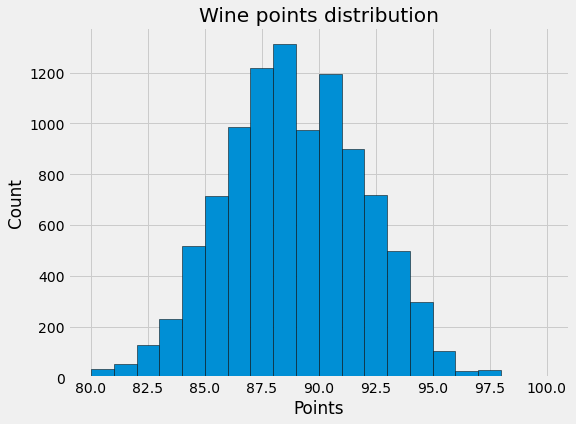

In [10]:
# Distribution of points
plt.style.use('fivethirtyeight')
plt.rc("figure", figsize=(8,6))
plt.hist(df['points'], bins = 20, edgecolor = 'k');
plt.xlabel('Points'); plt.ylabel('Count'); 
plt.title('Wine points distribution');

In [11]:
print("Mean: {:.2f}".format(df['points'].mean()))
print("Median: {:.2f}".format(df['points'].median()))

Mean: 88.46
Median: 88.00


PRICE

Intuitively, it's easy to imagine that there is a correlation between the price of the bottle and the rating of the wine. To find out it is true that higher quality wines are always more expensive, let's plot a graph of price vs points. 

Looking at our plot, we notice there is a slight upwards trend. To have a more concrete feeling of this correlation, we can calculate the Pearson correlation coefficient. 

The Pearson coefficient can be used to summarize the strength of the linear relationship between two data samples and is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. The score varies between -1 (full negative correlation) and 1 (full positive correlation), with 0 representing no correlation. 
In general, a score larger than 0.7 can be considered to represent a strong correlation. Scores between 0.4 and 0.7 represent a moderate correlation and scores below 0.4 represent a weak correlation.  

The corrwith() gives us a 0.42 Pearson coefficient, which indicates a moderate correlation between the price feature and our target. 

Looking at the graph, we notice that the majority of wines are concentrated in prices below 200 dollars. When we zoom in to see only the wines below 200 dollars, we see an even stronger correlation of 0.50.

Pearson correlation coefficient: 0.42


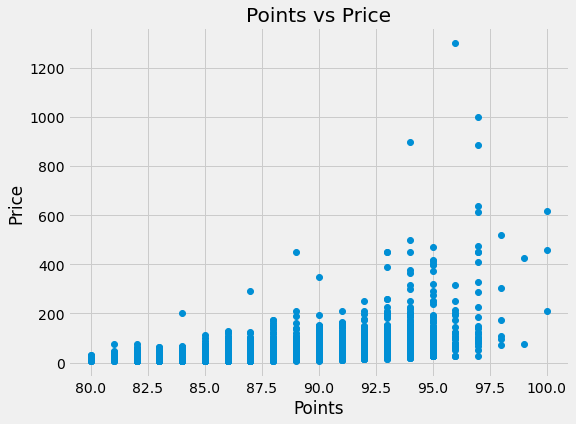

In [12]:
plt.plot(df['points'], df['price'], 'o')
plt.xlabel('Points'); plt.ylabel('Price'); 
plt.title('Points vs Price');
print("Pearson correlation coefficient: {:.2f}".format(df.corrwith(df['points'])['price']))

Pearson correlation coefficient: 0.50


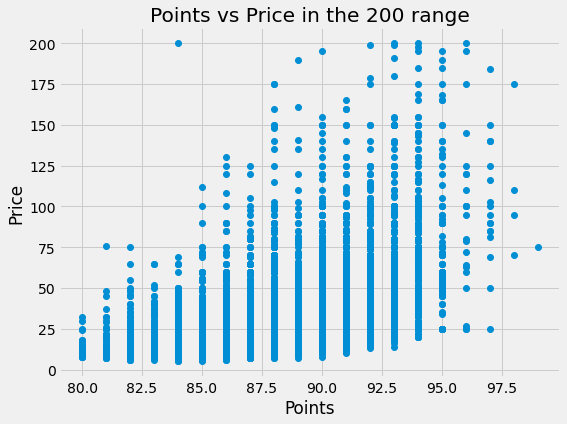

In [13]:
df_price200 = df.loc[df['price'] <= 200]
plt.plot(df_price200['points'], df_price200['price'], 'o')
plt.xlabel('Points'); plt.ylabel('Price'); 
plt.title('Points vs Price in the 200 range');
print("Pearson correlation coefficient: {:.2f}".format(df_price200.corrwith(df_price200['points'])['price']))

COUNTRY

Visualizing categorical features can be a little more complex than numerical ones.
For the next features we will be plotting a density plot of points by feature value, along with a boxplot so we can visualize if there are significant differences between the distribution of each feature value. Naturally, since there are a large number of unique values by feature, we will plot only the distribution for the 10 most common values. 

For the country feature, we will plot the distribution for the 10 most common countries:
US, France, Italy, Spain, Portugal, Chile, Argentina, Austria, Australia and Germany.

Looking at the plots, we notice countries that have a very different distribution of points (Austria and Chile, for instance), while others have more similar ones (Chile and Spain). Although country is not a decisive factor by itself, it can provide relevant information to our model. With further analysis, it can also bring interesting insights to our client, such as which countries usually provide higher quality wines.

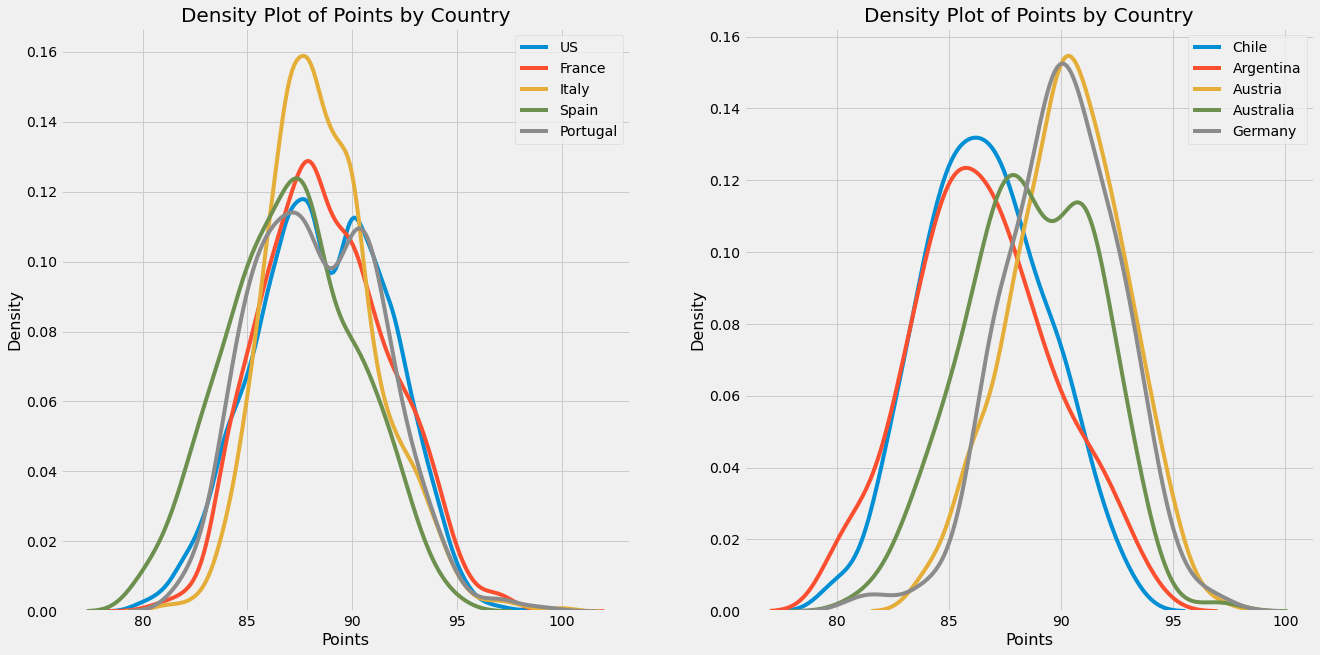

In [14]:
plt.figure(figsize=(20,10))

countries = ['US', 'France', 'Italy', 'Spain', 'Portugal'] 
countries2 = ['Chile', 'Argentina', 'Austria', 'Australia', 'Germany']
plt.subplot(1,2,1)
#plt.figure(figsize=(8,6)
for country in countries:
    data = df.loc[df['country'] == country]
    sns.kdeplot(data['points'], label = country)

plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Country', size = 20);
plt.legend()
    
plt.subplot(1,2,2)
for country in countries2:
    data = df.loc[df['country'] == country]
    sns.kdeplot(data['points'], label = country)
    
plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Country', size = 20);
plt.legend()


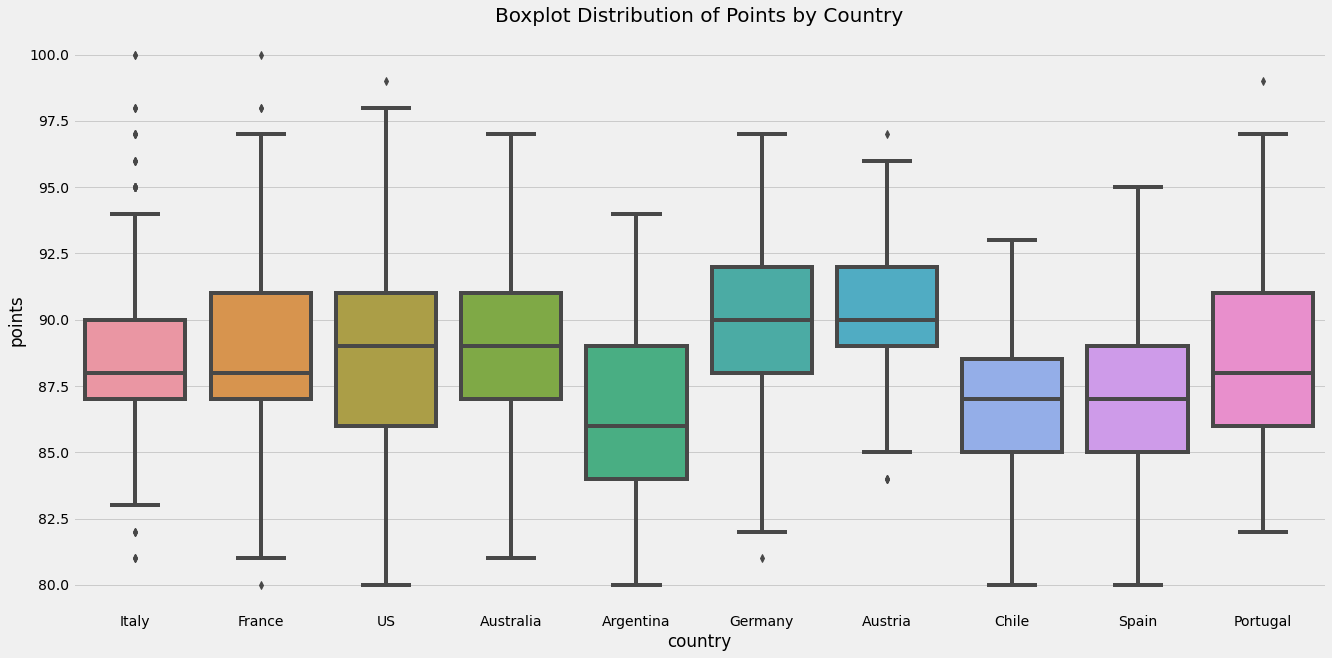

In [15]:
plt.figure(figsize=(20,10))
countries = ['US', 'France', 'Italy', 'Spain', 'Portugal', 'Chile', 'Argentina', 'Austria', 'Australia', 'Germany']
data = df.loc[df['country'].isin(countries)]
ax = sns.boxplot(x="country", y="points", data=data)
plt.title('Boxplot Distribution of Points by Country', size = 20);

TASTER NAME

Plotting the distribution of points per taster does not give us such distinct boxplots as with the country feature. This means that the Country feature will probably be more relevant to our model than the Taster name. 

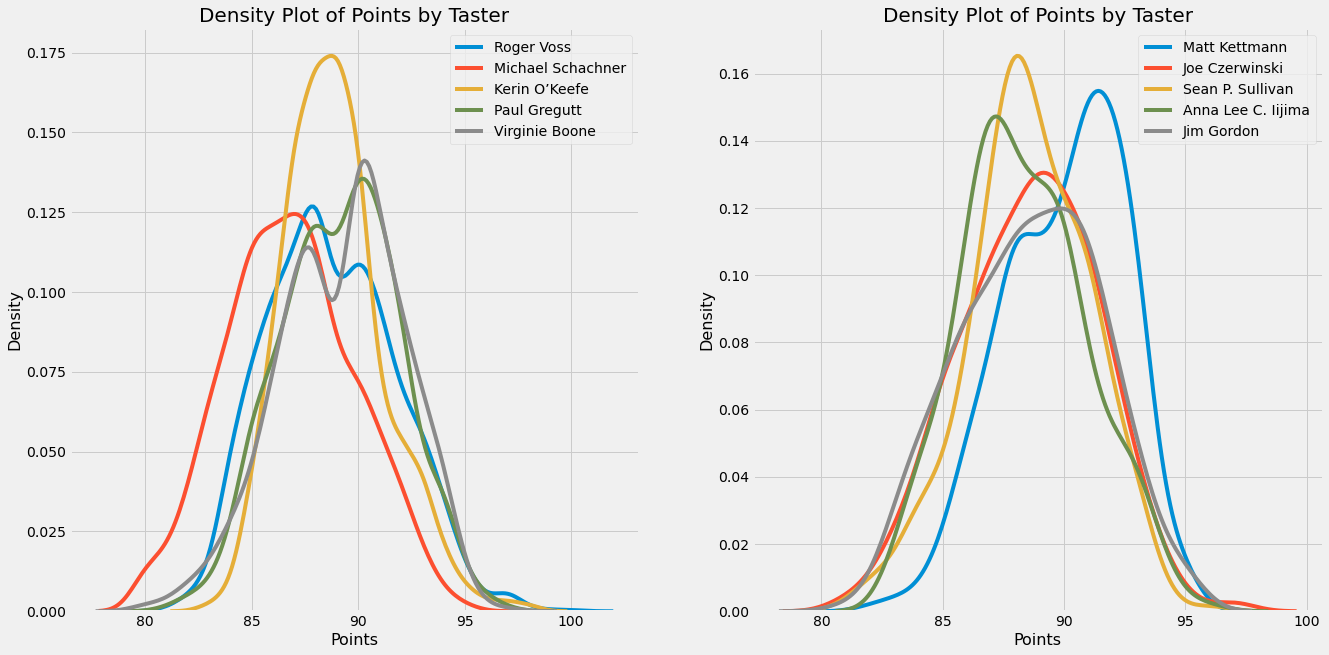

In [16]:
names = ['Roger Voss', 'Michael Schachner', 'Kerin O’Keefe', 'Paul Gregutt', 'Virginie Boone']
names2 = ['Matt Kettmann', 'Joe Czerwinski', 'Sean P. Sullivan', 'Anna Lee C. Iijima', 'Jim Gordon']

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
for name in names:
    data = df.loc[df['taster_name'] == name]
    sns.kdeplot(data['points'], label = name)

plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Taster', size = 20);
plt.legend()
    
plt.subplot(1,2,2)
for name in names2:
    data = df.loc[df['taster_name'] == name]
    sns.kdeplot(data['points'], label = name)
    
plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Taster', size = 20);
plt.legend()

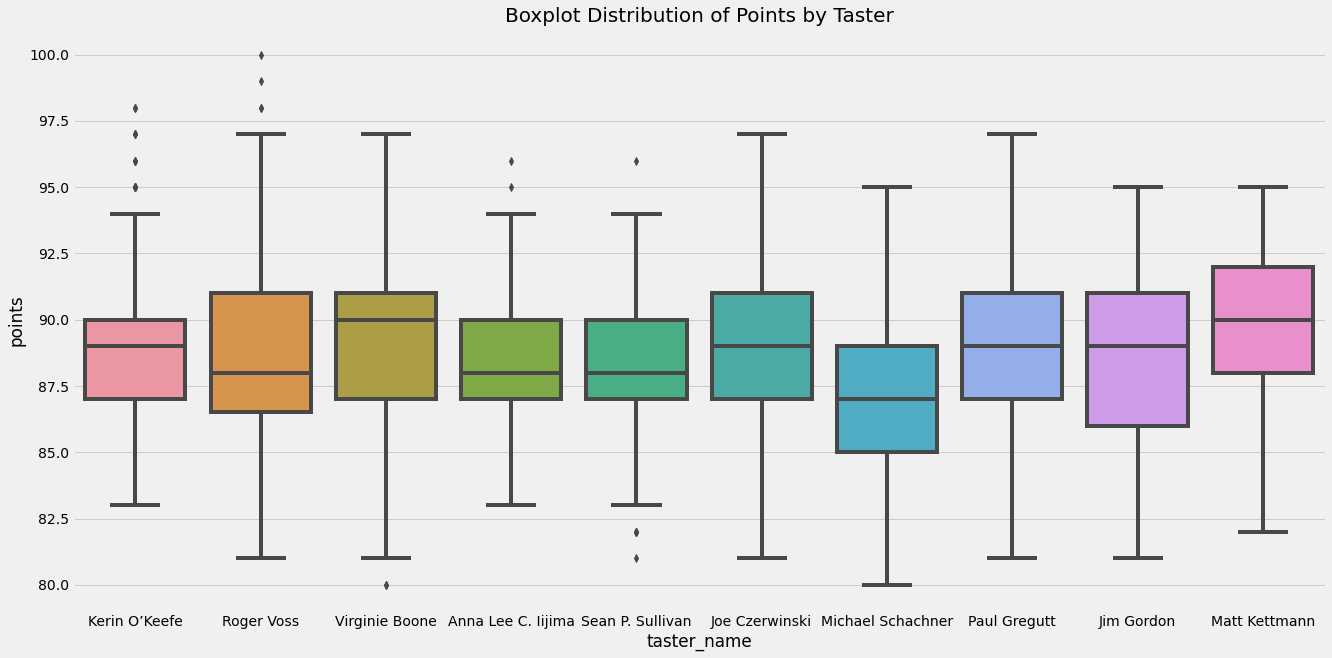

In [17]:
plt.figure(figsize=(20,10))
names = ['Roger Voss', 'Michael Schachner', 'Kerin O’Keefe', 'Paul Gregutt', 'Virginie Boone', 'Matt Kettmann', 'Joe Czerwinski', 'Sean P. Sullivan', 'Anna Lee C. Iijima', 'Jim Gordon']
data = df.loc[df['taster_name'].isin(names)]
ax = sns.boxplot(x="taster_name", y="points", data=data)
plt.title('Boxplot Distribution of Points by Taster', size = 20);

VARIETY

The graphs below show the density plots and boxplots for the Variety feature. 

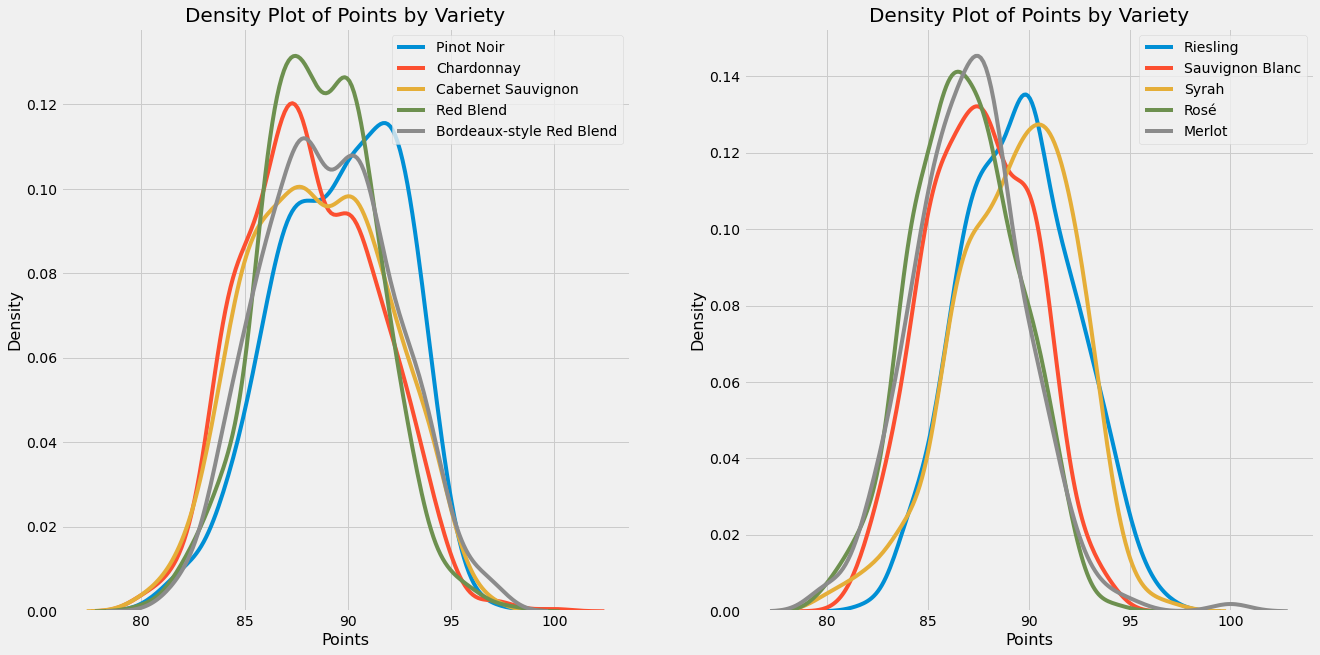

In [18]:
varieties = ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend']
varieties2 = ['Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot']

plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
for name in varieties:
    data = df.loc[df['variety'] == name]
    sns.kdeplot(data['points'], label = name)

plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Variety', size = 20);
plt.legend()
    
plt.subplot(1,2,2)
for name in varieties2:
    data = df.loc[df['variety'] == name]
    sns.kdeplot(data['points'], label = name)
    
plt.xlabel('Points', size = 16); plt.ylabel('Density', size = 16); 
plt.title('Density Plot of Points by Variety', size = 20);
plt.legend()

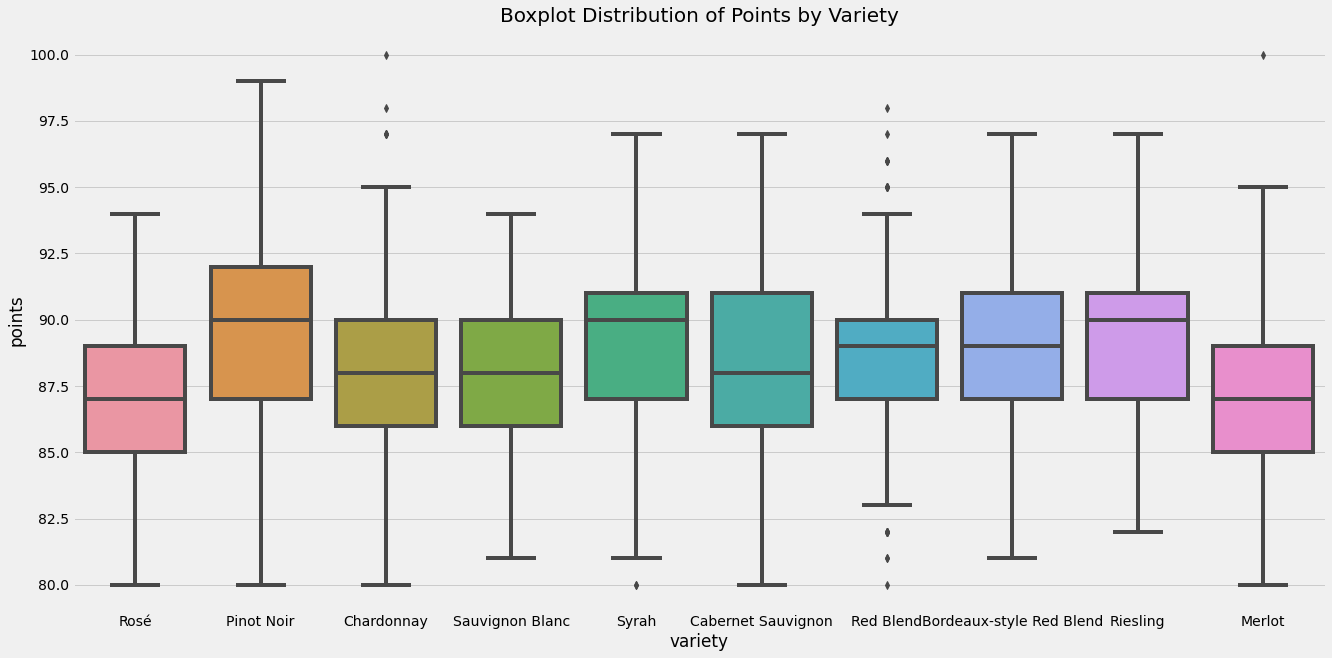

In [19]:
plt.figure(figsize=(20,10))
varieties = ['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend', 'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc', 'Syrah', 'Rosé', 'Merlot']
data = df.loc[df['variety'].isin(varieties)]
ax = sns.boxplot(x="variety", y="points", data=data)
plt.title('Boxplot Distribution of Points by Variety', size = 20);

Although the univariate distributions are interesting to see and can definitely generate some insights on the behavior of our data, this analysis is limited because it doesn't take into consideration the relationships that might exist between two or more features. 
The variables province and region_1, for instance, both relate to location and are subcategories inside the larger feature countries. Further exploratory data analysis should take into consideration these relationships. 

Since our main goal with this proof of concept machine learning model is to assess the feasibility of the predictor, we will restrict our analysis in this notebook to the univariate distributions alone. 

As stated earlier, exploratory data analysis is a good way to perform feature selection, but it is not the only one. 

The **MRUV algorithm** is a multivariate recursive feature elimination technique with a repeated double cross validation that helps identify relevant subsets of variables. 

After the section on Feature Extraction, we will run the python implementation of the MRUV algorithm in order to confirm that our variables are in fact relevant to our model. 

**FEATURE EXTRACTION**

This section has two parts. 

First, we are going to extract information from the 'description' and 'title' textual features.

- We can try to discover the general feeling of a text by passing it to a sentiment analysis tool. For this task, we will use VADER, which is an open source lexicon and rule based sentiment analysis tool. It atributes a score, called *compound*, to the sentence that measures the sentiment of a given sentence. The compound varies between -1 (extremely negative) to +1 (extremely positive). 

- From 'description' we will also get the length of the sentence.

- Title gives us information about the year of the wine, so we will extract this information from the text.

For the second part, we will encode our categorical variables so they can become inputs to our machine learning model.
Since our remaining features still have a lot of unique values (e.g.: variety with 333), we will hold out on using a one-hot encoder because it will produce a vary large number of columns in our matrix. 
A hashing encoder would fix the high dimensional space problem, but it would cause us to lose some of the explicability of our model.
Therefore, we will first try the ordinal encoder, which simply gives a number to each unique value of the column and see if we can achieve good results with it. 

COMPOUND

Let's see an example of Vader Sentiment's compound score

In [20]:
analyzerObj = SentimentIntensityAnalyzer()
sentence = df.iloc[8]['description']
points = df.iloc[8]['points']
score = analyzerObj.polarity_scores(sentence)
print("Wine Title: {}".format(df.iloc[8]['title']))
print("Wine Points: {}".format(df.iloc[8]['points']))
print("Sentence: {}".format(df.iloc[8]['description']))
print("Compound: {}\n".format(score['compound']))

sentence = df.iloc[9]['description']
points = df.iloc[9]['points']
score = analyzerObj.polarity_scores(sentence)
print("Wine Title: {}".format(df.iloc[9]['title']))
print("Wine Points: {}".format(df.iloc[9]['points']))
print("Sentence: {}".format(df.iloc[9]['description']))
print("Compound: {}".format(score['compound']))

Wine Title: Château Lamothe Guignard 2009  Sauternes
Wine Points: 94
Sentence: Gold in color, this is a wine with notes of spice, rich fruit and honey, which are all surrounded by intense botrytis. This is a wine that has great aging potential, and its superripeness develops slowly on the palate.
Compound: 0.8402

Wine Title: Château Boisson 2014  Bordeaux Blanc
Wine Points: 88
Sentence: Steel and nervy mineralogy are the hallmarks of this wine at this stage. It's still waiting for the fruit to develop, but expect crisp citrus and succulent apples. The aftertaste, tensely fresh now, should soften as the wine develops. This 90% Sauvignon Blanc and 10% Sémillon blend comes from the estate's small vineyard on the slope near Cadillac.
Compound: 0.0387


Here VADER gave a higher score to a higher ranked wine. 
But let's extract the feature and analyze it to see if compound it really a good feature.

Looking at the plot Points vs Compound, we can notice a slight upwards trend between the compound score and the number or points. 

The Pearson correlation coefficient shows us a weak correlation of 0.32

It's important to notice here that VADER is specifically tuned to sentiments expressed in social media. If taken to production, an effort could be made to tune VADER to our more specific text environment, which could potentially increase the correlation. 

In [21]:
def get_compound(description, analyzerObj):
    compound = analyzerObj.polarity_scores(description)['compound']
    return compound

df['compound'] = df['description'].map(lambda description: get_compound(description, analyzerObj))

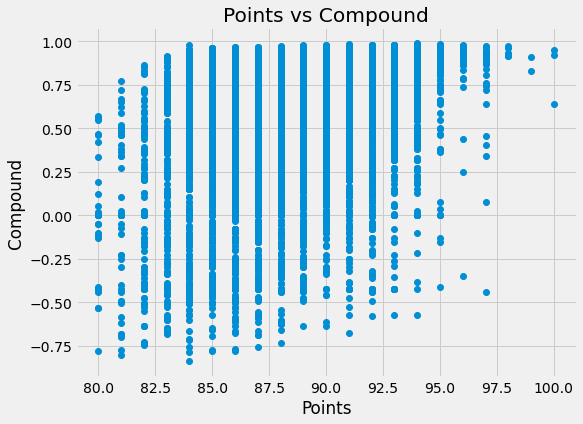

In [22]:
plt.plot(df['points'], df['compound'], 'o')
plt.xlabel('Points'); plt.ylabel('Compound'); 
plt.title('Points vs Compound');


In [23]:
print("Pearson correlation coefficient: {:.2f}".format(df.corrwith(df['points'])['compound']))

Pearson correlation coefficient: 0.32


DESCRIPTION LENGTH

Let's extract the description length information.

Here we notice a moderate correlation between description length and points, with a more clear upward trend in the graph and a Pearson coefficient of 0.55.

In [24]:
df['descLen'] = df['description'].map(lambda description: len(description))

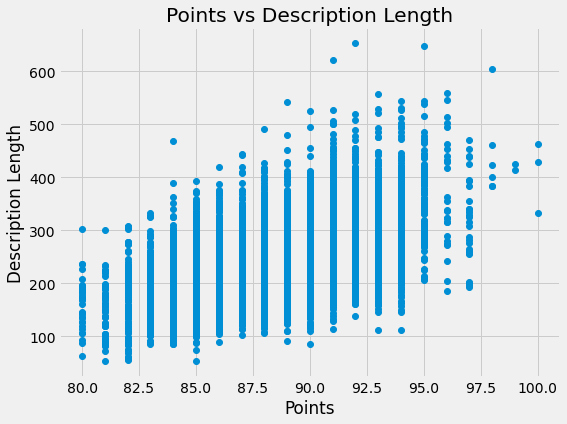

In [25]:
plt.plot(df['points'], df['descLen'], 'o')
plt.xlabel('Points'); plt.ylabel('Description Length'); 
plt.title('Points vs Description Length');

In [26]:
print("Pearson correlation coefficient: {:.2f}".format(df.corrwith(df['points'])['descLen']))

Pearson correlation coefficient: 0.55


YEAR

With the extracted variable year, we can not observe a clear correlation to our target. The Pearson coefficient in this case was only 0.4.

In [27]:
def get_year(title):
    if (re.search(r"(\d{4})", title)):
        year = int(re.search(r"(\d{4})", title).group(1))
        if (year <= date.today().year and year >= 1500):
            return year
    
    return 0
        

df['year'] = df['title'].map(lambda title: get_year(title))
median = df.loc[df['year']>0].median()['year']
df['year'].replace(0, median, inplace = True)

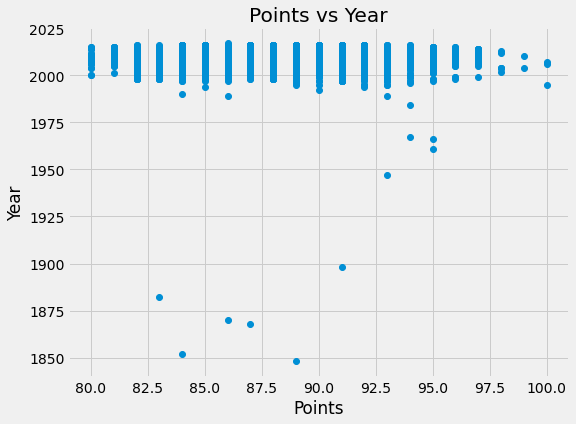

In [28]:
plt.plot(df['points'], df['year'], 'o')
plt.xlabel('Points'); plt.ylabel('Year'); 
plt.title('Points vs Year');

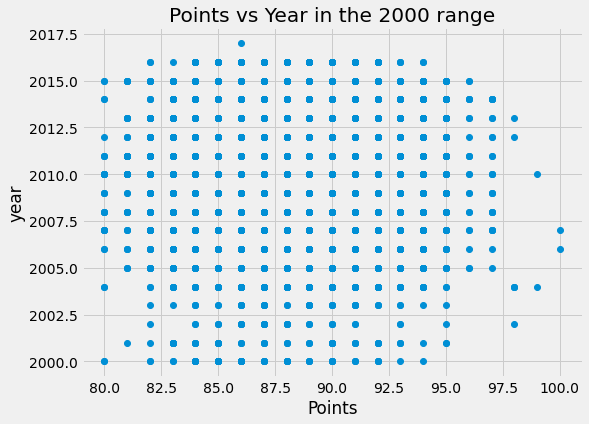

In [29]:
df_year2000 = df.loc[df['year'] >= 2000]
plt.plot(df_year2000['points'], df_year2000['year'], 'o')
plt.xlabel('Points'); plt.ylabel('year'); 
plt.title('Points vs Year in the 2000 range');

In [30]:
print("Pearson correlation coefficient: {:.2f}".format(df.corrwith(df['points'])['year']))
print("Pearson correlation coefficient: {:.2f}".format(df_year2000.corrwith(df_year2000['points'])['year']))

Pearson correlation coefficient: 0.04
Pearson correlation coefficient: 0.05


ORDINAL ENCODER FOR CATEGORICAL FEATURES

Let's encode our categorical features using the ordinal encoder tool. 
We have five features here: 'country', 'province', 'region_1', 'taster_name' and 'variety'

In [31]:
X = df.drop(columns=['points', 'description', 'title'])
y = df['points']
X.head()

,country,price,province,region_1,taster_name,variety,compound,descLen,year
0,Italy,30.0,Northeastern Italy,Alto Adige,Kerin O’Keefe,Sauvignon,0.9403,222,2012.0
1,France,22.0,Loire Valley,Sancerre,Roger Voss,Rosé,0.4404,174,2014.0
2,Italy,25.0,Tuscany,Chianti Classico,0,Sangiovese,0.6369,162,2009.0
3,US,50.0,California,Russian River Valley,Virginie Boone,Pinot Noir,0.6705,268,2012.0
4,US,38.0,California,Russian River Valley,Virginie Boone,Chardonnay,0.4404,326,2013.0


In [32]:
ce_ord = ce.OrdinalEncoder(cols = ['country', 'province', 'region_1', 'taster_name', 'variety'])
X_labeled = ce_ord.fit_transform(X, y)
X_labeled.head()

/Users/camila/miniconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,country,price,province,region_1,taster_name,variety,compound,descLen,year
0,1,30.0,1,1,1,1,0.9403,222,2012.0
1,2,22.0,2,2,2,2,0.4404,174,2014.0
2,1,25.0,3,3,3,3,0.6369,162,2009.0
3,3,50.0,4,4,4,4,0.6705,268,2012.0
4,3,38.0,4,4,4,5,0.4404,326,2013.0


FEATURE SELECTION - MURV Algorithm

We notice a moderate correlation for the features 'descLen' and 'compound', but a very weak correlation for the 'year' feature.

As stated earlier, univariate analysis is important and gives us interesting information about the behaviour of our variables, but it ignores the relationships that can exist between them. To check if the extracted features should be selected to train our model, we will use **multivariate analysis** by using a python implementation of the **MURV algorithm**. 

The **MRUV algorithm** is a multivariate recursive feature elimination technique with a repeated double cross validation that helps identify relevant subsets of variables. 
The tool we used is available at https://github.com/datarevenue-berlin/py-MUVR.
This tool was run in the notebook **'Feature Selection with Py-MUVR - Label encoder'** and we will the results here.


As stated in the GitHub README.md file: 

The feature selector returns 3 possible feature sets:

min: "The minimum number of features for which the model performs optimally.
The minimal set of most informative features. If you choose less features, then the model will perform worse."

max: "The maximum number of features for which the model performs optimally.
The all-relevant feature set. This includes also all weak and redundant, but still relevant features – without including noisy and uninformative features. Using more features would also decrease the performance of the mode."

mid: "The geometric mean of both feature sets."

For our analysis, the results were as follows: 

* min: 'descLen', 'price', 'compound', 'year'
* max: 'descLen', 'price', 'compound', 'year', 'country', 'province', 'variety', 'region_1', 'taster_name'
* mid: 'descLen', 'price', 'compound', 'year', 'country', 'province'

It's interesting to see that even though in the univariate analysis the 'year' feature didn't appear to be relevant to our model, in the multivariate analysis it appeared in the min subset. 
All three ouf our engineered features appeared in the min subset, showing us that they bring relevant information and should be included in the training of our model.
It's also interesting to note that the max subset did not exclude any of the current columns of the dataset, so we will not exclude any of them from training.

We would also like to note that this tool was made for omics studies, which have a very large number of features. 
Even though our example does not have a large number of features, we thought running the tool was an interesting exercise in features selection. 
Just for fun, we run the tool with a one-hot encoding of the variables (**'Feature Selection with Py-MUVR - Dummy encoder'** notebook) and got the following min subset of features:

'descLen', 'price', 'compound', 'taster_name_Michael Schachner', 'variety_Pinot Noir', 'region_1_California', 'province_Mendoza Province', 'country_Spain', 'region_1_Mendoza', 'country_Chile', 'taster_name_Matt Kettmann', 'taster_name_Anne Krebiehl\xa0MW', 'country_Austria', 'variety_Rosé', 'variety_Pinot Grigio', 'province_California', 'country_US', 'region_1_Russian River Valley', 'province_Northern Spain', 'region_1_Brunello di Montalcino', 'taster_name_Virginie Boone', 'province_Central Valley', 'region_1_Rioja', 'province_Virginia', 'region_1_Virginia', 'region_1_Barolo', 'variety_Merlot', 'variety_Nebbiolo', 'variety_Tempranillo', 'variety_Carmenère', 'variety_Riesling', 'variety_Malbec', 'province_Piedmont', 'province_Other', 'region_1_Bordeaux', 'province_Champagne', 'region_1_Champagne', 'variety_Champagne Blend', 'province_New York', 'country_Germany', 'year', 'province_Maule Valley', 'province_Wachau', 'taster_name_Paul Gregutt', 'province_Tuscany', 'variety_Sangiovese Grosso', 'region_1_Walla Walla Valley (WA)', 'region_1_Sta. Rita Hills', 'variety_Torrontés', 'province_Burgundy', 'region_1_Anderson Valley', 'variety_Sauvignon Blanc', 'region_1_Pessac-Léognan', 'region_1_Navarra', 'region_1_Saint-Julien', 'region_1_Bordeaux Supérieur', 'province_Central Italy', 'taster_name_Roger Voss', 'region_1_Saint-Émilion', 'country_France', 'region_1_Paso Robles', 'region_1_Napa Valley', 'variety_Verdejo', 'region_1_Rueda'

We see that descLen, price and compound are still the top three most relevant features and that year is still in the min subset. If we choose to take the proof of concept model to production, further analysis could be made with both the choice of encoder and the choice of feature subsets to train our model. 



**MODEL TRAINING**

In this section we will be training a few machine learning models to decide which one to use for our proof of concept Wine Rating predictor.

We will start with on of the most simple machine learning algorithms for regression, the Linear Regression. It will serve as our baseline to evaluate other algorithms.

The algorithms we will train: 
- Linear Regression (baseline)
- PLSR
- Random Forest
- Gradient Boost
- XGBOOST

To evaluate the performance of the algorithms, we will be using the **Mean Squared Error metric (MSE)**.
The MSE measures the average squared difference between the actual values and the predicted values. It is a very commonly used metric to evaluate regression algorithms.

TRAIN X TEST SPLIT

Before starting the training, we will split our dataset for train and test purposes.
We will leave 20% of the examples for the test dataset. 

Since we will be testing the models with their default hyperparameters, there is no need for a validation set. 
If taken to production, the validation set will be created for purposes of tuning the hyperparameters of the model. 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y, test_size=0.2, random_state=0)

LINEAR REGRESSION - Baseline

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:

linReg = LinearRegression().fit(X_train, y_train)
y_pred = linReg.predict(X_test)
linReg_error = metrics.mean_squared_error(y_test, y_pred)
print("MSE for Linear Regression: {:.2f}".format(linReg_error))

MSE for Linear Regression: 5.00


PLSR - Partial Least Squares Regression

In [36]:
from sklearn.cross_decomposition import PLSRegression

In [37]:
plsr = PLSRegression(n_components=4)
plsr.fit(X_train, y_train)
y_pred=plsr.predict(X_test)
plsr_error = metrics.mean_squared_error(y_test, y_pred)
print("MSE for PLSR: {:.2f}".format(plsr_error))

MSE for PLSR: 5.00


RANDOM FOREST

In [38]:
randomForest=RandomForestRegressor(random_state=0)
randomForest.fit(X_train,y_train)
y_pred=randomForest.predict(X_test)
randomForest_error = metrics.mean_squared_error(y_test, y_pred)
print("MSE for Random Forest: {:.2f}".format(randomForest_error))

MSE for Random Forest: 3.74


GRADIENT BOOST

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

In [40]:
gb=GradientBoostingRegressor(random_state=0)
gb.fit(X_train,y_train)
y_pred=gb.predict(X_test)
gb_error = metrics.mean_squared_error(y_test, y_pred)
print("MSE for Gradient Boost: {:.2f}".format(gb_error))

MSE for Gradient Boost: 3.69


XGBOOST

In [41]:
import xgboost
from xgboost import XGBRegressor

In [42]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train, verbose=False)
y_pred=xgb.predict(X_test)
xgb_error = metrics.mean_squared_error(y_test, y_pred)
print("MSE for XGBRegressor: {:.2f}".format(xgb_error))

MSE for XGBRegressor: 3.55


The XGBoost algorithm gave us the best results, with a MSE of 3.55. 

**MODEL EVALUATION** 


Based on the previous section, we chose the **XGBoost** algorithm as the oficial model for our proof of concept predictor. The XGBoost is an optimized version of the Gradient Boost algorithm, both of them based on decision trees. 
It obtained the best result our of the five trained algorithms, with a **3.55 MSE**. 

Let's start by visualizing some of the prediction our model made. 

In [43]:
print("Actual rating of five first wines: {}".format(y_test.values[0:5]))
print("Predicted rating of five first wines: {}".format(y_pred[0:5]))

Actual rating of five first wines: [85 85 87 85 92]
Predicted rating of five first wines: [86.43445 85.77748 86.39695 86.17321 91.13946]


This looks like an excellent result, with the predicted ratings being very close to the actual expert ratings.

We can also look at the distribution of predicted points compared to the actuall distribution of points.

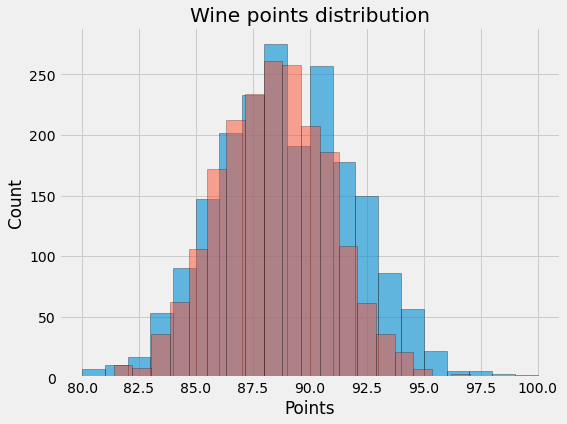

In [44]:
plt.style.use('fivethirtyeight')
plt.rc("figure", figsize=(8,6))
plt.hist(y_test.values, bins = 20, edgecolor = 'k', alpha = 0.6)
plt.hist(y_pred, bins = 20, edgecolor = 'k', alpha = 0.5)
plt.xlabel('Points'); plt.ylabel('Count'); 
plt.title('Wine points distribution');

To better understand our model, we can plot the importance of each feature with the plot_importance() that comes with the xgboost python library. It gives a simple bar-chart with the importance of each feature in our dataset.

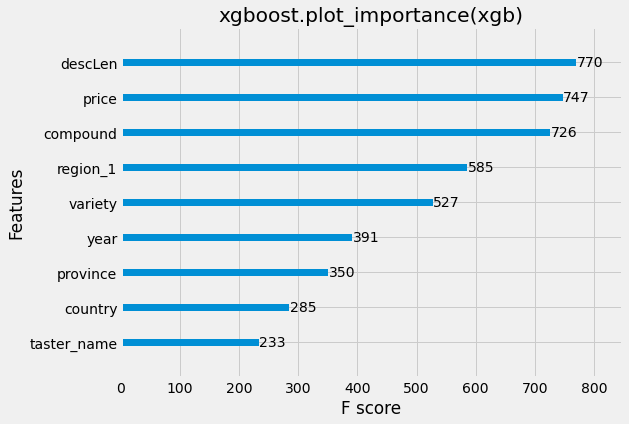

In [45]:
xgboost.plot_importance(xgb)
plt.title("xgboost.plot_importance(xgb)")
plt.show()

Although this looks interesting, we were surprised to see that region_1 was ranked #4 in feature importance.
Turns out the plot_importance method has three importance types: weight (default), cover and gain. 
According to XGBoost documentation (https://xgboost.readthedocs.io/en/latest/python/python_api.html), the three options above determine how the importance is calculated.
- Weight: "number of times a feature appears in a tree"
- Gain: "average gain of splits which use the feature"
- Cover: "average cover of splits which use the feature where coverage is defined as the number of samples affected by the split"

Plotting the importance of features according to the three methods gives us different importance ranks, as can be seen with the graphs below. Region_1, for instance, is ranked as #4, #1 and #7 respectively.

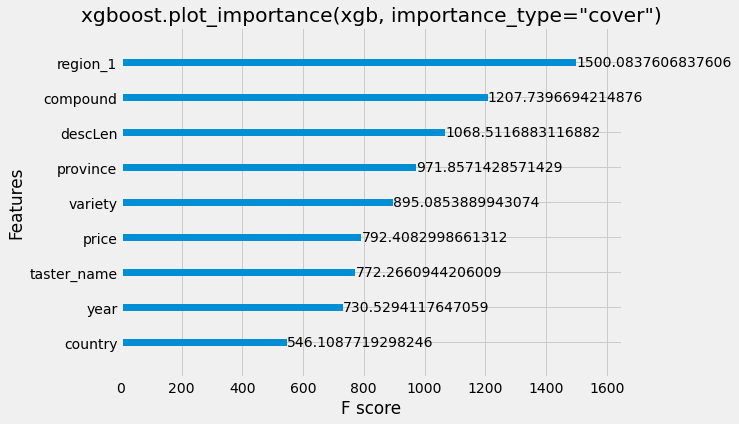

In [46]:
xgboost.plot_importance(xgb, importance_type="cover")
plt.title('xgboost.plot_importance(xgb, importance_type="cover")')
plt.show()

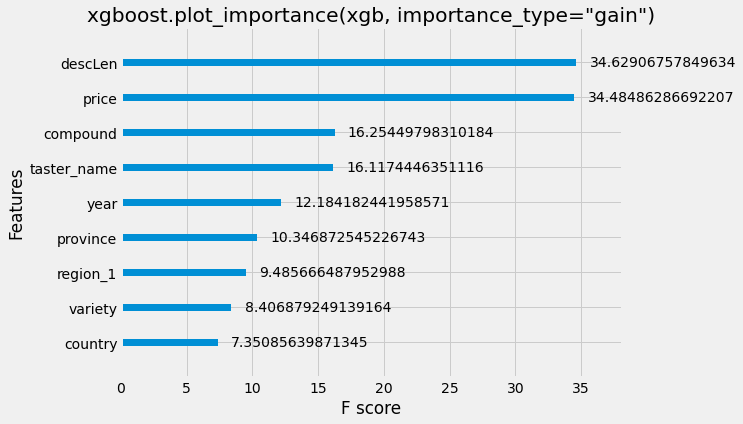

In [47]:
xgboost.plot_importance(xgb, importance_type="gain")
plt.title('xgboost.plot_importance(xgb, importance_type="gain")')
plt.show()

In the paper "A Unified Approach to Interpreting Model Prediction", Scott M. Lundberg and Su-In Lee present a unified framework for interpreting predictions, SHAP (SHapley Additive exPlanations). According to the paper, Tree Shap is a consistent and accurate method to interpret prediction. 

The shap library for python has tools to create graphs that can help with the interpretability of the model. 

In [48]:
import shap

In [49]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_labeled)

In [50]:
shap.initjs()

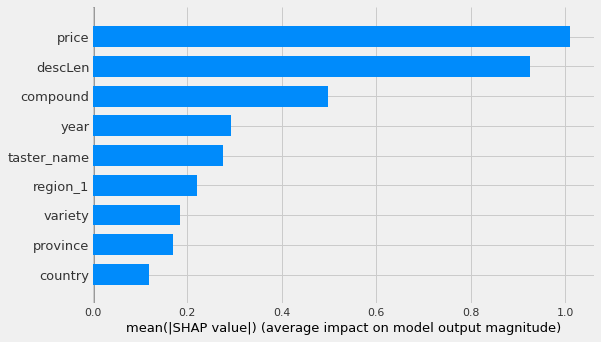

In [51]:
shap.summary_plot(shap_values, X_labeled, plot_type="bar")

Plotting the feature importance with shap shows us that the most relevant features (price, descLen, compound and year) are the same as with the MURV algorithm. This confirms the importance of the Feature Extraction section of this project. 

Shap also allows us to visualize the explanation for a single prediction.  

In [52]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_labeled.iloc[0,:])

Summary plots use a density scatter plot of SHAP values for each feature. Each wine has one dot in each row.

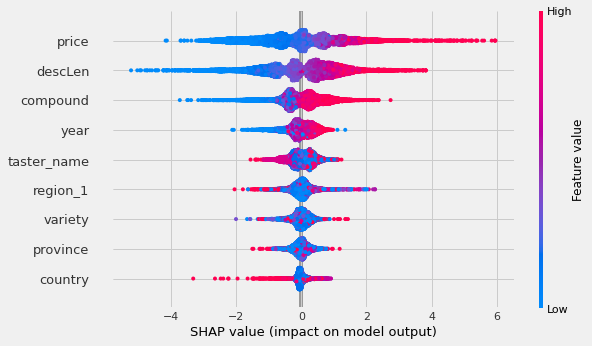

In [53]:
shap.summary_plot(shap_values, X_labeled)

Dependency plots shows relationships between pairs of features and can be used in further analysis to gain insights for our customer. 

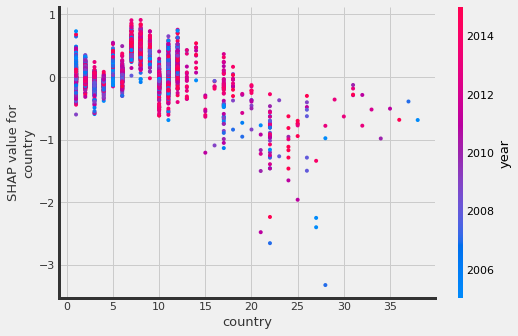

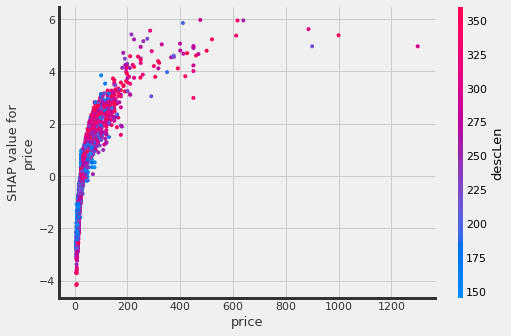

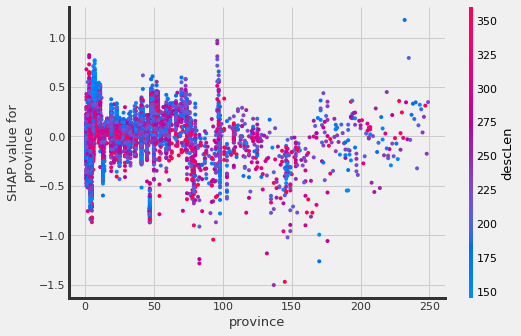

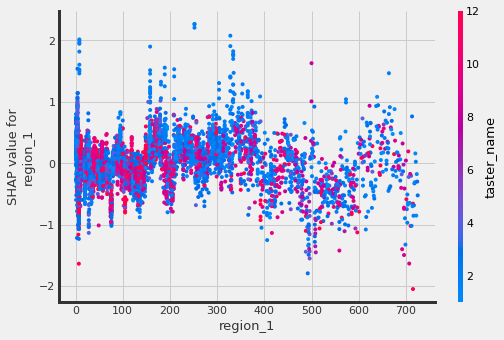

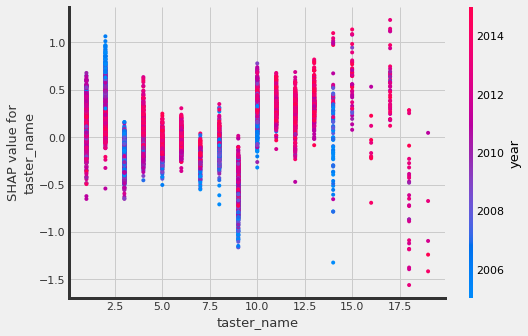

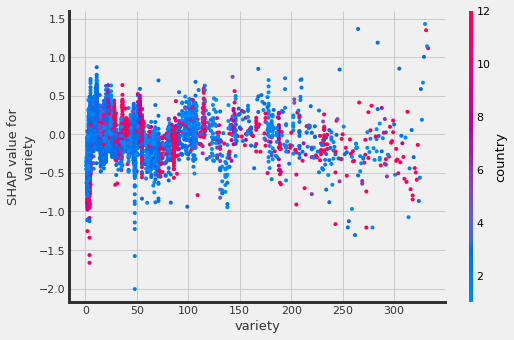

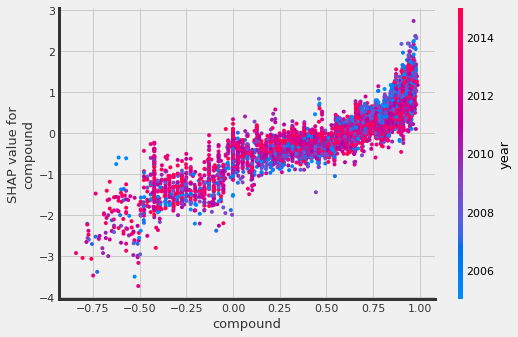

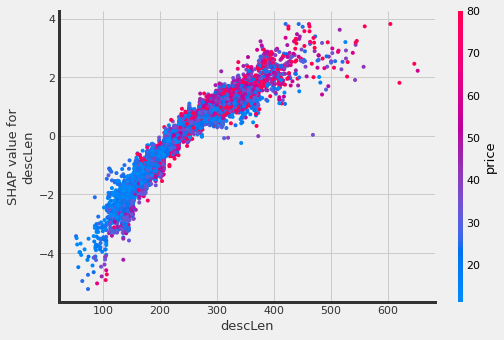

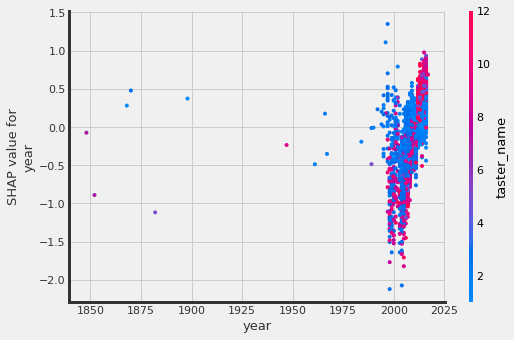

In [54]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_labeled, display_features=X_labeled)

**CONCLUSION**

Using a basic linear regression model as our baseline, we achieved a 5.0 MSE in our regression problem. 

We were able to improve this performance by using a XGBoost model with default hyperparameters, which achieved a 3.55 MSE. 

We believe that this result can be further improved by tuning both the hyperparameter and the VADER sentiment analysis tool to our specific case. More experiments with different types of encoders can also help us achieve higher result.

We recommend implementing a full production solution, not only for the promising predictor metrics, but also for its potential to provide important insight to our costumer about their products and comercial partners.

More technical details and further graphical visualization can be found on the attached 